In [1]:
%run inference__1_loading.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from pandas.core.window.rolling import Rolling
from pprint import pprint
from typing import Dict, List, Tuple, Union

# import pandas_bokeh
# pandas_bokeh.output_notebook()
# pd.set_option('plotting.backend', 'pandas_bokeh')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

In [3]:
def sigma_series(df: pd.DataFrame, col_name: str="vals", w: int = 3, sigma: int = 3) -> pd.DataFrame:
    df_mean: float = df[col_name].mean()
    df_rolling: Rolling = df[col_name].rolling(window=w)
    df_rolling_mean: pd.Series = df_rolling.mean()
    df_rolling_std: pd.Series = df_rolling.std()

    new_cols: dict = {
        (col_name, "mean", str(w), "w"): df_rolling_mean,
        (col_name, "std", str(w), "w"): df_rolling_std,
        (col_name, "residual", str(w), "w"): lambda df: (df.vals - df_rolling_mean),
        (col_name, "zscore", str(w), "w"): lambda df: df["_".join((col_name, "residual", str(w), "w"))] / df_rolling_std,
        (col_name, "lower", str(w), "w", str(sigma), "s"): df_rolling_mean - (sigma * df_rolling_std),
        (col_name, "upper", str(w), "w", str(sigma), "s"): df_rolling_mean + (sigma * df_rolling_std),
    }
    return df.assign(**{"_".join(k): v for k, v in new_cols.items()})#.drop(columns=["train_set", "test_set", "anomaly_set", "vals"])

In [4]:
pprint(input_files[:5])

[PosixPath('/home/paulo/Documents/mba_tcc/data/2_final/0__input/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.parquet'),
 PosixPath('/home/paulo/Documents/mba_tcc/data/2_final/0__input/002_UCR_Anomaly_DISTORTED2sddb40_35000_56600_56900.parquet'),
 PosixPath('/home/paulo/Documents/mba_tcc/data/2_final/0__input/003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.parquet'),
 PosixPath('/home/paulo/Documents/mba_tcc/data/2_final/0__input/004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.parquet'),
 PosixPath('/home/paulo/Documents/mba_tcc/data/2_final/0__input/005_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature1_4000_5391_5392.parquet')]


In [5]:
file_index: pd.DataFrame = pd.read_parquet(file_index_path / "files_index.parquet")

---

In [22]:
def run(idx: int):
    datafile = input_files[idx-1]
    print(datafile)
    train_file: pd.DataFrame = pd.read_parquet(datafile)
    train_file.info()

    file_infos: dict = file_index[file_index.file_number == idx].to_dict(orient="records")[0]
    pprint(file_infos)
    
    plot_range = (
        int(file_infos["anomaly_index_start"] * 0.99),
        int(file_infos["anomaly_index_end"] * 1.01)
    )
    print("plot_range:", plot_range) 

    if "pandas_bokeh" in sys.modules:
        train_file.plot_bokeh.hist()
    else:
        train_file.vals.plot.hist()
    plt.show()
    
    sub_anomaly = train_file.loc[slice(*plot_range), ["vals", "anomaly_set", "test_set"]]
    ax = sub_anomaly.plot.line(figsize=(14, 6), secondary_y=["anomaly_set", "test_set"])
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='lower left')
    plt.show()
    
    w = 0
    while True:
        w = w + 3

        result = sigma_series(train_file[train_file.test_set == 1], w=w)
        
        zscore_col = f"vals_zscore_{w}_w"
        zscores = result.loc[result.anomaly_set == 1, zscore_col]
        if zscores.min() < -3 or zscores.max() > 3:
            break
    
    result.loc[result.anomaly_set == 0, [zscore_col]] = np.nan
    results: pd.DataFrame = pd.concat([
        train_file,
        result[[zscore_col]]
    ], axis=1).loc[slice(*plot_range), :]
    
    # result.info(verbose=True)
    secondary_y: List[str] = list(results.drop(columns=["vals"]).columns)

    ax = results.plot.line(
        figsize=(14, 6),
        secondary_y=secondary_y,
    )
    plt.axhline(3, color="red", linestyle="dotted")
    plt.axhline(-3, color="red", linestyle="dotted")
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='lower left')
    plt.show()

---

/home/paulo/Documents/mba_tcc/data/2_final/0__input/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79795 entries, 0 to 79794
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vals         79795 non-null  float64
 1   train_set    79795 non-null  int64  
 2   test_set     79795 non-null  int64  
 3   anomaly_set  79795 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.4 MB
{'anomaly_index_end': 52620,
 'anomaly_index_start': 52000,
 'file_name': '001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt',
 'file_number': 1,
 'file_path': '/home/paulo/Documents/mba_tcc/data/0_raw/UCR_Anomaly_FullData/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt',
 'mnemonic': 'DISTORTED1sddb40',
 'row_count': 79795,
 'training_index_end': 35000}
plot_range: (51480, 53146)


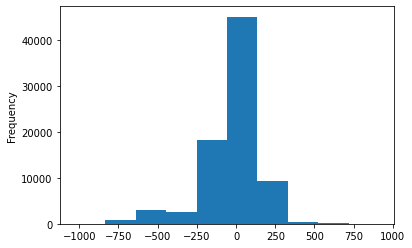

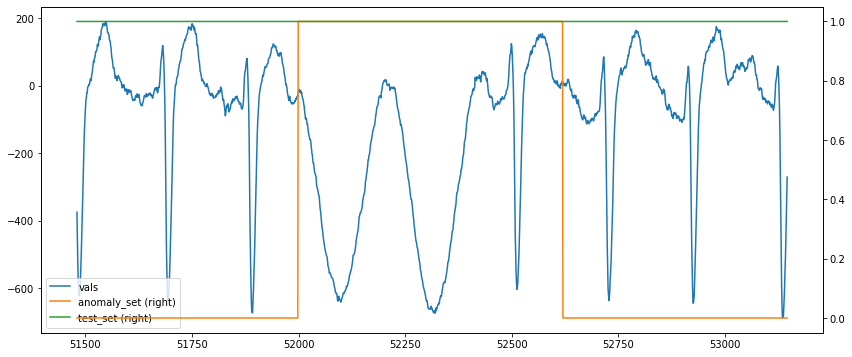

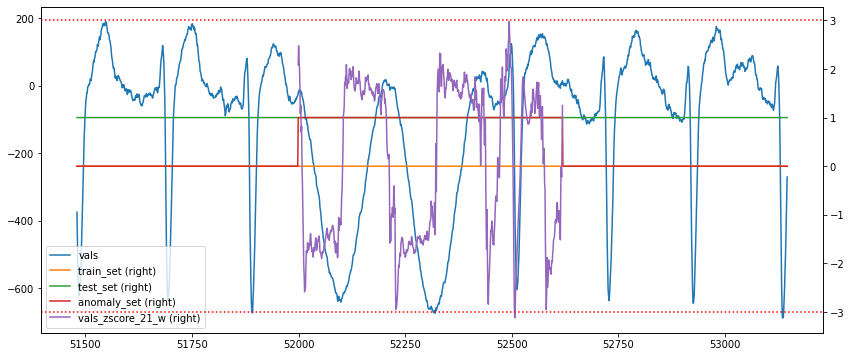

In [23]:
run(1)

/home/paulo/Documents/mba_tcc/data/2_final/0__input/015_UCR_Anomaly_DISTORTEDECG4_5000_16800_17100.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   vals         200000 non-null  float64
 1   train_set    200000 non-null  int64  
 2   test_set     200000 non-null  int64  
 3   anomaly_set  200000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 6.1 MB
{'anomaly_index_end': 17100,
 'anomaly_index_start': 16800,
 'file_name': '015_UCR_Anomaly_DISTORTEDECG4_5000_16800_17100.txt',
 'file_number': 15,
 'file_path': '/home/paulo/Documents/mba_tcc/data/0_raw/UCR_Anomaly_FullData/015_UCR_Anomaly_DISTORTEDECG4_5000_16800_17100.txt',
 'mnemonic': 'DISTORTEDECG4',
 'row_count': 200000,
 'training_index_end': 5000}
plot_range: (16632, 17271)


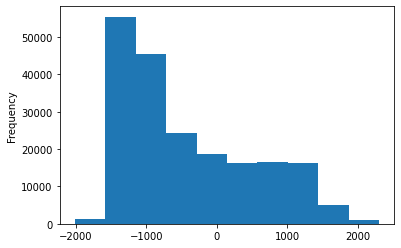

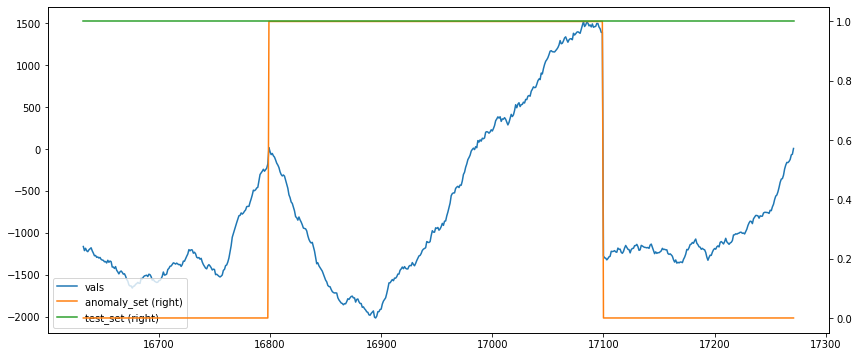

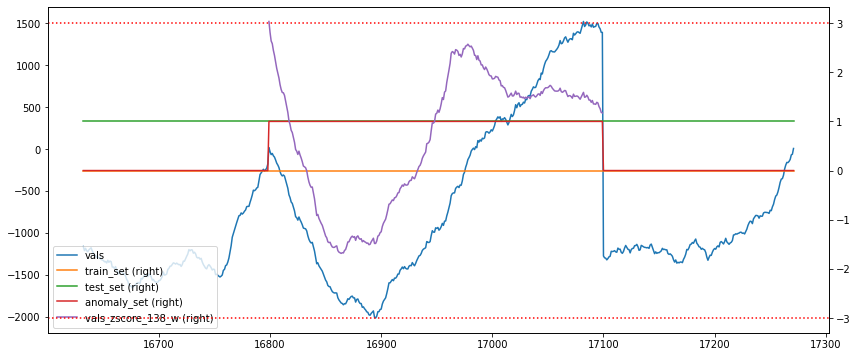

In [24]:
run(15)

/home/paulo/Documents/mba_tcc/data/2_final/0__input/159_UCR_Anomaly_TkeepSecondMARS_3500_9330_9340.parquet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11388 entries, 0 to 11387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vals         11388 non-null  float64
 1   train_set    11388 non-null  int64  
 2   test_set     11388 non-null  int64  
 3   anomaly_set  11388 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 356.0 KB
{'anomaly_index_end': 9340,
 'anomaly_index_start': 9330,
 'file_name': '159_UCR_Anomaly_TkeepSecondMARS_3500_9330_9340.txt',
 'file_number': 159,
 'file_path': '/home/paulo/Documents/mba_tcc/data/0_raw/UCR_Anomaly_FullData/159_UCR_Anomaly_TkeepSecondMARS_3500_9330_9340.txt',
 'mnemonic': 'TkeepSecondMARS',
 'row_count': 11388,
 'training_index_end': 3500}
plot_range: (9236, 9433)


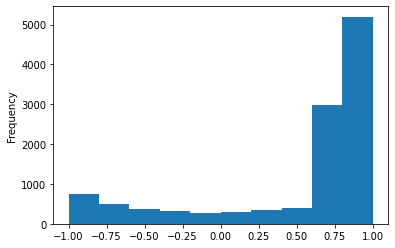

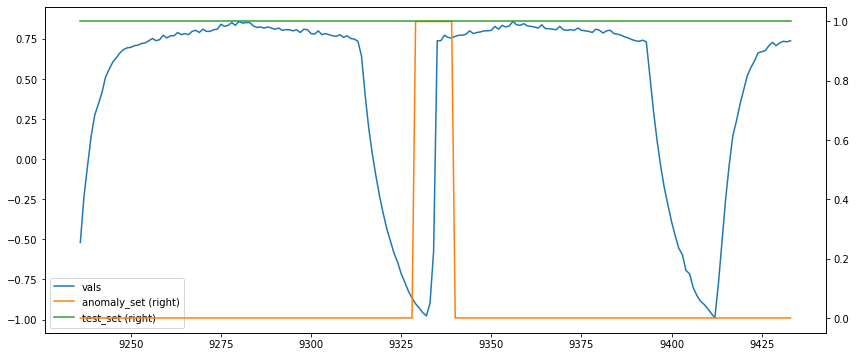

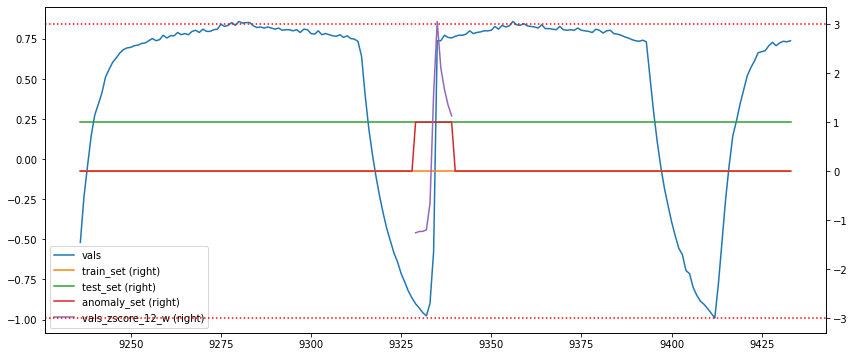

In [25]:
run(159)